In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Network

## Day - 10; Session - 01; PyTorch

## Simple RNN

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix

In [3]:
print (fn_plot_tf_hist.__doc__)


    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    


In [4]:
print (fn_plot_confusion_matrix.__doc__)


    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    


In [5]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../Input'
outDir = '../Output'
modelDir = '../Models'
subDir = 'weather'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 20 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'medium',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [6]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

## Read Weather data set

In [7]:
data_df = pd.read_csv(os.path.join(inpDir, 'weatherHistory.csv'))
data_df.shape

(96453, 12)

In [8]:
data_df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [9]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


In [10]:
data_df['datetime'] = pd.to_datetime(data_df['Formatted Date'], utc = True)

In [11]:
data_df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary,datetime
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.,2006-03-31 22:00:00+00:00
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.,2006-03-31 23:00:00+00:00
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.,2006-04-01 00:00:00+00:00
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.,2006-04-01 01:00:00+00:00
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.,2006-04-01 02:00:00+00:00


In [12]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   Formatted Date            96453 non-null  object             
 1   Summary                   96453 non-null  object             
 2   Precip Type               95936 non-null  object             
 3   Temperature (C)           96453 non-null  float64            
 4   Apparent Temperature (C)  96453 non-null  float64            
 5   Humidity                  96453 non-null  float64            
 6   Wind Speed (km/h)         96453 non-null  float64            
 7   Wind Bearing (degrees)    96453 non-null  float64            
 8   Visibility (km)           96453 non-null  float64            
 9   Loud Cover                96453 non-null  float64            
 10  Pressure (millibars)      96453 non-null  float64            
 11  Daily Summary  

In [13]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature (C),96453.0,11.932678,9.551546,-21.822222,4.688889,12.0000,18.838889,39.905556
Apparent Temperature (C),96453.0,10.855029,10.696847,-27.716667,2.311111,12.0000,18.838889,39.344444
Humidity,96453.0,0.734899,0.195473,0.000000,0.600000,0.7800,0.890000,1.000000
Wind Speed (km/h),96453.0,10.810640,6.913571,0.000000,5.828200,9.9659,14.135800,63.852600
Wind Bearing (degrees),96453.0,187.509232,107.383428,0.000000,116.000000,180.0000,290.000000,359.000000
Visibility (km),96453.0,10.347325,4.192123,0.000000,8.339800,10.0464,14.812000,16.100000
Loud Cover,96453.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
Pressure (millibars),96453.0,1003.235956,116.969906,0.000000,1011.900000,1016.4500,1021.090000,1046.380000


In [14]:
data_df.columns

Index(['Formatted Date', 'Summary', 'Precip Type', 'Temperature (C)',
       'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover',
       'Pressure (millibars)', 'Daily Summary', 'datetime'],
      dtype='object')

In [15]:
num_cols = ['Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 
            'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 
            'Loud Cover', 'Pressure (millibars)']

len(num_cols)

8

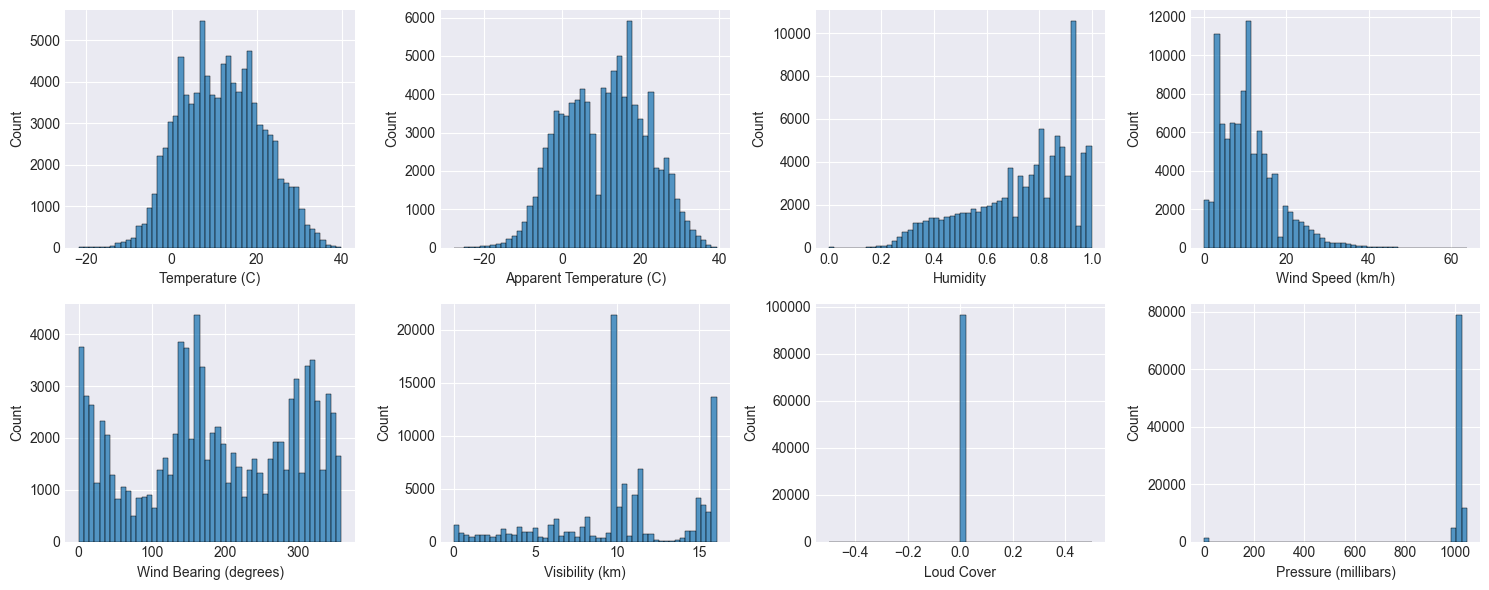

In [16]:
fig, axes = plt.subplots(2,4)

axes = axes.ravel()

for count, col in enumerate(num_cols):
    
    ax = axes[count]
    
    sns.histplot(data=data_df, x=col, ax=ax, bins=50)
    
plt.tight_layout()

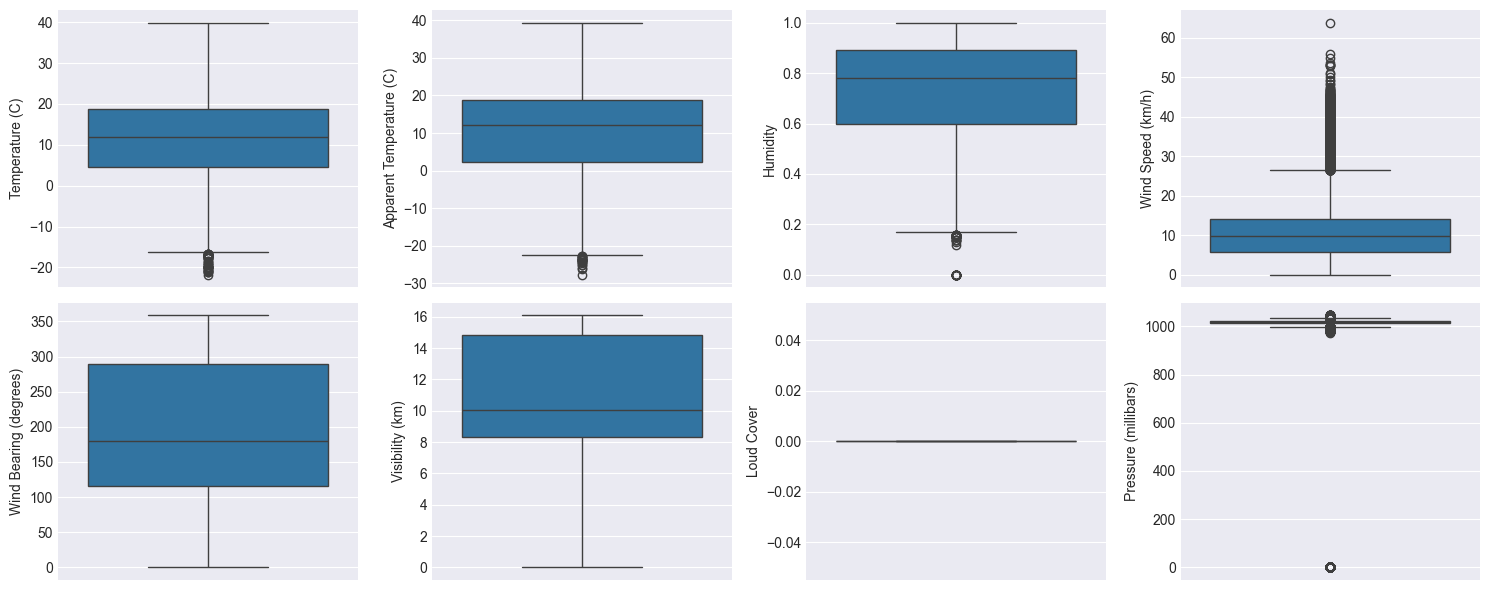

In [17]:
fig, axes = plt.subplots(2,4)

axes = axes.ravel()

for count, col in enumerate(num_cols):
    
    ax = axes[count]
    
    sns.boxplot(data=data_df, y = col, ax = ax)
    
plt.tight_layout()

<Axes: >

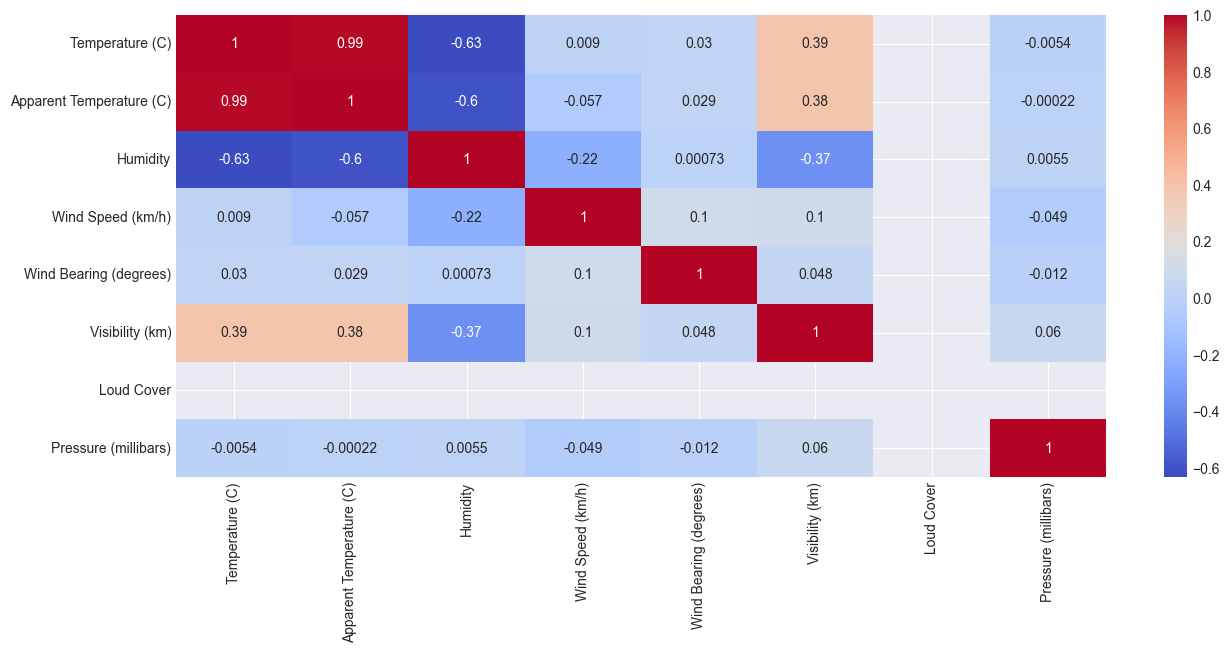

In [18]:
sns.heatmap(data_df[num_cols].corr(), annot=True, cmap=CMAP)

In [19]:
temp_df = data_df[['datetime','Temperature (C)']].sort_values('datetime', axis=0, ascending=True)
temp_df = temp_df.reset_index(drop=True)
temp_df.head()

,datetime,Temperature (C)
0,2005-12-31 23:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,1.161111
2,2006-01-01 01:00:00+00:00,1.666667
3,2006-01-01 02:00:00+00:00,1.711111
4,2006-01-01 03:00:00+00:00,1.183333


In [20]:
temp_df = temp_df.rename({'Temperature (C)':'temp'}, axis=1)
temp_df.head()

,datetime,temp
0,2005-12-31 23:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,1.161111
2,2006-01-01 01:00:00+00:00,1.666667
3,2006-01-01 02:00:00+00:00,1.711111
4,2006-01-01 03:00:00+00:00,1.183333


<Axes: xlabel='datetime'>

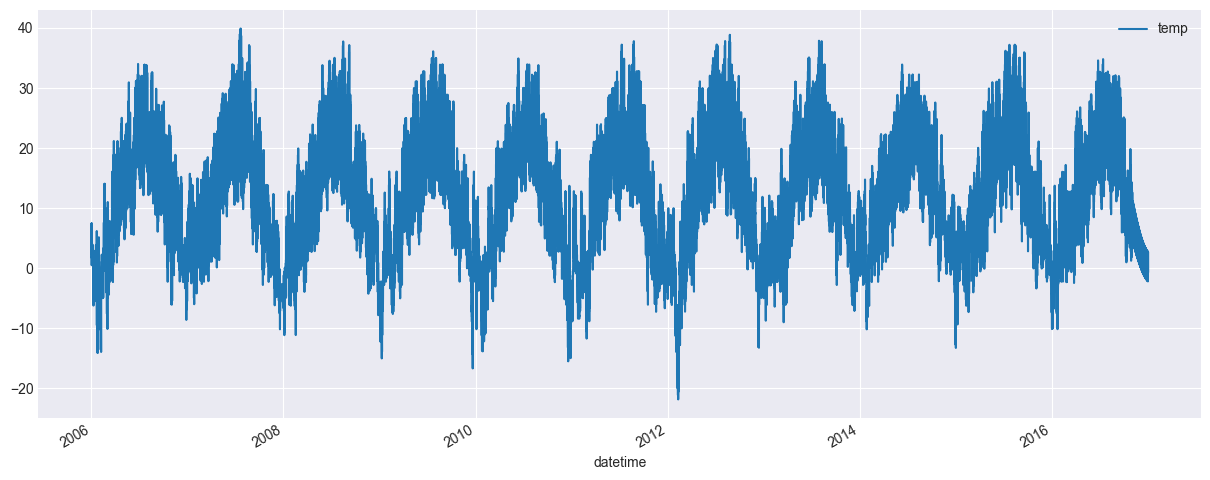

In [22]:
temp_df.plot(x='datetime', y='temp')

<Axes: xlabel='datetime', ylabel='temp'>

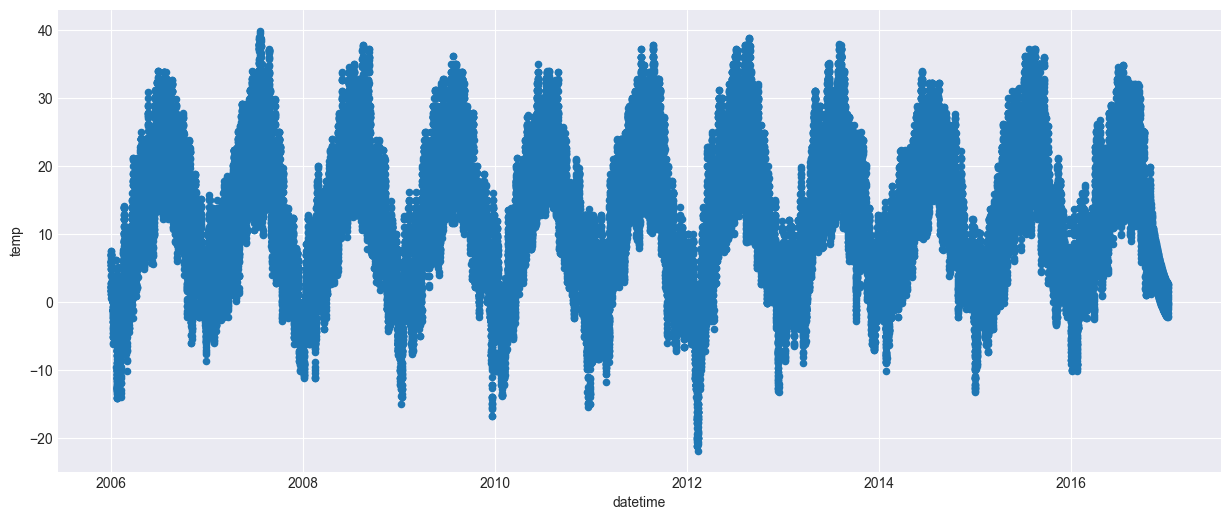

In [21]:
temp_df.plot(kind='scatter', x='datetime', y='temp')

In [60]:
h_units=100
input_shape = (time_step-1, 1)

model = tf.keras.Sequential()

model.add(tf.keras.layers.SimpleRNN(
    h_units,
    input_shape = input_shape,
    activation='tanh',
))

model.add(tf.keras.layers.Dense(1, activation='linear'))

model.compile (loss = 'mean_squared_error', optimizer = 'adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [61]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 100)               10200     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 10301 (40.24 KB)
Trainable params: 10301 (40.24 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
len(model.get_weights())

5

In [29]:
wax = model.get_weights()[0].shape
waa = model.get_weights()[1].shape
baa = model.get_weights()[2].shape

way = model.get_weights()[3].shape
bay = model.get_weights()[4].shape

wax, waa, baa, way, bay

((10000, 100), (100, 100), (100,), (100, 1), (1,))

In [31]:
temp_df.head(30)

,datetime,temp
0,2005-12-31 23:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,1.161111
2,2006-01-01 01:00:00+00:00,1.666667
3,2006-01-01 02:00:00+00:00,1.711111
4,2006-01-01 03:00:00+00:00,1.183333
5,2006-01-01 04:00:00+00:00,1.205556
6,2006-01-01 05:00:00+00:00,2.222222
7,2006-01-01 06:00:00+00:00,2.072222
8,2006-01-01 07:00:00+00:00,2.200000
9,2006-01-01 08:00:00+00:00,2.733333


In [36]:
time_step = 24

y_idx = np.arange(time_step,temp_df.shape[0], time_step)
y_idx
y_idx.shape

y_df = temp_df.iloc[y_idx]
y_df

,datetime,temp
24,2006-01-01 23:00:00+00:00,5.422222
48,2006-01-02 23:00:00+00:00,1.694444
72,2006-01-03 23:00:00+00:00,2.200000
96,2006-01-04 23:00:00+00:00,1.666667
120,2006-01-05 23:00:00+00:00,1.805556
...,...,...
96336,2016-12-27 02:00:00+00:00,-1.627778
96360,2016-12-28 02:00:00+00:00,-1.677778
96384,2016-12-29 02:00:00+00:00,-1.727778
96408,2016-12-30 02:00:00+00:00,-1.777778


In [38]:
X_df = temp_df.iloc[range(len(y_df)*time_step)]
X_df.shape

(96432, 2)

In [52]:
X = np.reshape(X_df['temp'].to_numpy(),(y_df.shape[0], time_step))
X = X[:,:23]
X.shape

(4018, 23)

# Input Shape expected  ===> [batch, timesteps, feature]

In [56]:
X = np.reshape(X, [X.shape[0], X.shape[1], 1])

In [57]:
split = int(y_df.shape[0]*(1-TEST_SIZE))

X_train = X[:split]
X_test = X[split:]

y_train = y_df['temp'].to_numpy()[:split]
y_test = y_df['temp'].to_numpy()[split:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3214, 23, 1), (804, 23, 1), (3214,), (804,))

In [62]:
history = model.fit(X_train, y_train,
                    validation_data=[X_test, y_test],
                    batch_size = BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=2)

Epoch 1/20

101/101 - 4s - loss: 28.7976 - root_mean_squared_error: 5.3663 - val_loss: 3.1312 - val_root_mean_squared_error: 1.7695 - 4s/epoch - 43ms/step
Epoch 2/20
101/101 - 1s - loss: 3.7674 - root_mean_squared_error: 1.9410 - val_loss: 1.3629 - val_root_mean_squared_error: 1.1674 - 828ms/epoch - 8ms/step
Epoch 3/20
101/101 - 1s - loss: 2.1054 - root_mean_squared_error: 1.4510 - val_loss: 1.0531 - val_root_mean_squared_error: 1.0262 - 916ms/epoch - 9ms/step
Epoch 4/20
101/101 - 1s - loss: 1.6559 - root_mean_squared_error: 1.2868 - val_loss: 1.2996 - val_root_mean_squared_error: 1.1400 - 780ms/epoch - 8ms/step
Epoch 5/20
101/101 - 1s - loss: 1.4290 - root_mean_squared_error: 1.1954 - val_loss: 0.7836 - val_root_mean_squared_error: 0.8852 - 794ms/epoch - 8ms/step
Epoch 6/20
101/101 - 1s - loss: 1.2209 - root_mean_squared_error: 1.1049 - val_loss: 0.7721 - val_root_mean_squared_error: 0.8787 - 833ms/epoch - 8ms/step
Epoch 7/20
101/101 - 1s - loss: 1.1815 - root_mean_squared_error: 1.08

In [63]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error
0,28.797646,5.366344,3.131210,1.769523
1,3.767447,1.940991,1.362863,1.167417
2,2.105393,1.450997,1.053112,1.026212
3,1.655896,1.286816,1.299610,1.140005
4,1.429015,1.195414,0.783639,0.885234


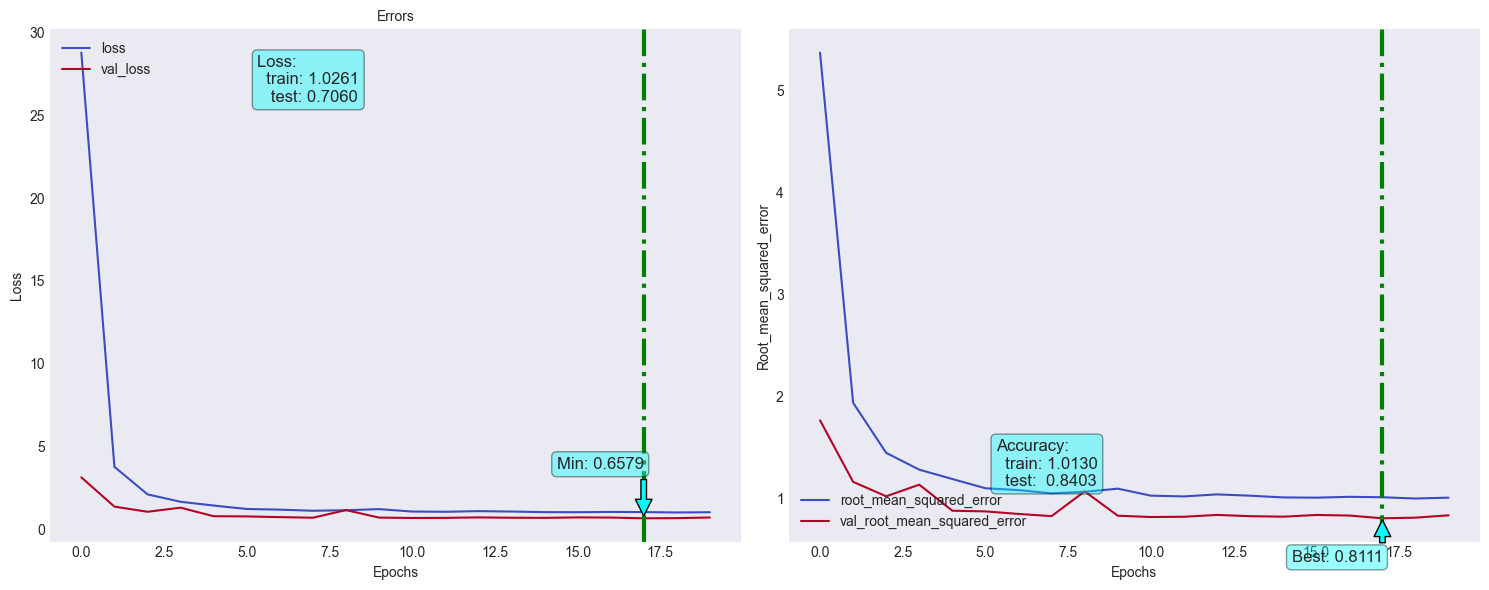

In [64]:
fn_plot_tf_hist(loss_df)

In [65]:
loss_df[loss_df['val_loss'] == loss_df['val_loss'].min()]

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error
17,1.034,1.016858,0.657872,0.811093


In [67]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_pred = np.append(y_train_pred, y_test_pred)

y_pred.shape

26/26 [==============================] - 0s 4ms/step


(4018,)

In [68]:
res_df = y_df.copy()
res_df['pred'] = y_pred

res_df

,datetime,temp,pred
24,2006-01-01 23:00:00+00:00,5.422222,4.994753
48,2006-01-02 23:00:00+00:00,1.694444,1.663066
72,2006-01-03 23:00:00+00:00,2.200000,1.880642
96,2006-01-04 23:00:00+00:00,1.666667,1.863384
120,2006-01-05 23:00:00+00:00,1.805556,2.279015
...,...,...,...
96336,2016-12-27 02:00:00+00:00,-1.627778,-1.163776
96360,2016-12-28 02:00:00+00:00,-1.677778,-1.211566
96384,2016-12-29 02:00:00+00:00,-1.727778,-1.258416
96408,2016-12-30 02:00:00+00:00,-1.777778,-1.303137


### How we can make it more Accurate ?

- Add more Fatures
- Add more Data (Interpret it Hourly basis or subgroups as Hourly)